In [62]:
# Regenerate churn probability if needed (in case it's not present)
if 'churn_probability' not in df.columns:
    import numpy as np
    np.random.seed(42)
    df['churn_probability'] = np.random.rand(len(df))

# Normalize revenue or use MonthlyCharges as proxy if MonthlyTenureRevenue not present
if 'MonthlyTenureRevenue' in df.columns:
    df['revenue_norm'] = (df['MonthlyTenureRevenue'] - df['MonthlyTenureRevenue'].min()) / \
                         (df['MonthlyTenureRevenue'].max() - df['MonthlyTenureRevenue'].min())
else:
    df['revenue_norm'] = (df['MonthlyCharges'] - df['MonthlyCharges'].min()) / \
                         (df['MonthlyCharges'].max() - df['MonthlyCharges'].min())

# Create risk score
df['risk_score'] = df['churn_probability'] * df['revenue_norm']

# Create risk segments
risk_bins = [0, 0.25, 0.5, 0.75, 1.0]
risk_labels = ['Low Risk', 'Medium Risk', 'High Risk', 'Very High Risk']
df['risk_segment'] = pd.cut(df['risk_score'], bins=risk_bins, labels=risk_labels)


In [5]:
import pandas as pd
import numpy as np
from catboost import CatBoostClassifier, Pool
import shap
import matplotlib.pyplot as plt
import joblib

# Load model and threshold from previous notebook's output
model = CatBoostClassifier()
model.load_model("/kaggle/input/churnshap/catboost_churn_model.cbm")
best_thresh = joblib.load("/kaggle/input/churnshap/best_threshold.pkl")

# Load processed churn data
df = pd.read_csv("/kaggle/input/cleanedchurneddata/cleaned_churn_data.csv")


In [6]:
print("Model and threshold loaded successfully!")
print(f"Best threshold: {best_thresh}")

print("Data preview:")
print(df.head())


Model and threshold loaded successfully!
Best threshold: 0.4500000000000001
Data preview:
   gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  Female              0     Yes         No       1           No   
1    Male              0      No         No      34          Yes   
2    Male              0      No         No       2          Yes   
3    Male              0      No         No      45           No   
4  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity OnlineBackup  \
0  No phone service             DSL             No          Yes   
1                No             DSL            Yes           No   
2                No             DSL            Yes          Yes   
3  No phone service             DSL            Yes           No   
4                No     Fiber optic             No           No   

  DeviceProtection TechSupport StreamingTV StreamingMovies        Contract  \
0               No  

In [7]:
# Step 1: Preprocess data
y = df["Churn"].map({"No": 0, "Yes": 1})
X = df.drop("Churn", axis=1)

# Identify categorical features (column indices)
cat_features = [i for i, col in enumerate(X.columns) if X[col].dtype == "object"]

print("Categorical feature indices:", cat_features)
print("Feature names:", X.columns.tolist())


Categorical feature indices: [0, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]
Feature names: ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges']


In [22]:
# 4. Identify categorical features
cat_features_indices = [i for i, col in enumerate(X.columns) if X[col].dtype == "object"]
print("Categorical feature indices:", cat_features_indices)
print("Feature names:", X.columns.tolist())

Categorical feature indices: [0, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]
Feature names: ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges']


In [24]:
import pandas as pd
import numpy as np
from catboost import CatBoostClassifier, Pool
import shap
import matplotlib.pyplot as plt
import joblib

# 1. Load model and threshold
model = CatBoostClassifier()
model.load_model("/kaggle/input/churnshap/catboost_churn_model.cbm")
best_thresh = joblib.load("/kaggle/input/churnshap/best_threshold.pkl")

# 2. Load data
df = pd.read_csv("/kaggle/input/cleanedchurneddata/cleaned_churn_data.csv")

print("Model and threshold loaded successfully!")
print(f"Best threshold: {best_thresh}")
print("Data preview:")
print(df.head())

# 3. Prepare X and y
y = df["Churn"].map({"No": 0, "Yes": 1})
X = df.drop("Churn", axis=1)

# 4. Identify categorical features
cat_features_indices = [i for i, col in enumerate(X.columns) if X[col].dtype == "object"]
print("Categorical feature indices:", cat_features_indices)
print("Feature names:", X.columns.tolist())


Model and threshold loaded successfully!
Best threshold: 0.4500000000000001
Data preview:
   gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  Female              0     Yes         No       1           No   
1    Male              0      No         No      34          Yes   
2    Male              0      No         No       2          Yes   
3    Male              0      No         No      45           No   
4  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity OnlineBackup  \
0  No phone service             DSL             No          Yes   
1                No             DSL            Yes           No   
2                No             DSL            Yes          Yes   
3  No phone service             DSL            Yes           No   
4                No     Fiber optic             No           No   

  DeviceProtection TechSupport StreamingTV StreamingMovies        Contract  \
0               No  

In [27]:
# Step 1: Load original data (df) and drop target column
X_raw = df.drop('Churn', axis=1)

# Step 2: One-hot encode categorical features to match model input
X_processed = pd.get_dummies(X_raw)

# Step 3: Check if your processed X matches model.feature_names_
missing_cols = set(model.feature_names_) - set(X_processed.columns)
extra_cols = set(X_processed.columns) - set(model.feature_names_)

print(f"Missing columns in X_processed: {missing_cols}")
print(f"Extra columns in X_processed: {extra_cols}")

# Step 4: Add missing columns with zeros
for col in missing_cols:
    X_processed[col] = 0

# Step 5: Reorder columns to match model.feature_names_
X_processed = X_processed[model.feature_names_]

# Step 6: Create Pool (no categorical features now, since all are numeric)
pool_for_shap = Pool(data=X_processed)

# Step 7: Calculate SHAP values
shap_values = model.get_feature_importance(data=pool_for_shap, type='ShapValues')

# Step 8: Exclude last column (expected value)
shap_values = shap_values[:, :-1]

print("SHAP values calculated successfully!")


Missing columns in X_processed: {'Partner', 'DeviceProtection', 'OnlineSecurity', 'MonthlyTenureRevenue', 'StreamingMovies', 'TechSupport', 'StreamingTV', 'ChurnRiskScore', 'PhoneService', 'gender', 'OnlineBackup', 'Dependents', 'PaperlessBilling'}
Extra columns in X_processed: {'InternetService_DSL', 'DeviceProtection_No internet service', 'Dependents_No', 'StreamingMovies_Yes', 'StreamingTV_Yes', 'OnlineSecurity_No', 'DeviceProtection_No', 'TechSupport_No internet service', 'MultipleLines_No', 'Partner_No', 'PhoneService_Yes', 'StreamingMovies_No internet service', 'PaperlessBilling_Yes', 'TechSupport_No', 'OnlineSecurity_No internet service', 'StreamingMovies_No', 'PaymentMethod_Bank transfer (automatic)', 'PaperlessBilling_No', 'DeviceProtection_Yes', 'TechSupport_Yes', 'Partner_Yes', 'PhoneService_No', 'StreamingTV_No internet service', 'OnlineBackup_No internet service', 'gender_Male', 'gender_Female', 'OnlineBackup_Yes', 'StreamingTV_No', 'Dependents_Yes', 'OnlineBackup_No', 'Co

In [29]:
# Convert tenure and monthly charges to numeric if not already
X_processed['tenure'] = pd.to_numeric(X_processed['tenure'], errors='coerce')
X_processed['MonthlyCharges'] = pd.to_numeric(X_processed['MonthlyCharges'], errors='coerce')

# Create MonthlyTenureRevenue = MonthlyCharges * tenure (example assumption)
X_processed['MonthlyTenureRevenue'] = X_processed['MonthlyCharges'] * X_processed['tenure']

# ChurnRiskScore could be a placeholder numeric column; if unknown, fill zeros or mean
X_processed['ChurnRiskScore'] = 0  # Or use domain knowledge if available


In [30]:
# Make sure numeric columns are float
for col in ['MonthlyCharges', 'TotalCharges', 'tenure', 'MonthlyTenureRevenue', 'ChurnRiskScore']:
    X_processed[col] = pd.to_numeric(X_processed[col], errors='coerce')

# You can check for missing values now and fill if needed
X_processed.fillna(0, inplace=True)


In [31]:
# Now reorder columns to match model.feature_names_
missing_cols = set(model.feature_names_) - set(X_processed.columns)
extra_cols = set(X_processed.columns) - set(model.feature_names_)

print(f"Missing columns now: {missing_cols}")
print(f"Extra columns now: {extra_cols}")

# For any missing columns, add zero filled columns
for col in missing_cols:
    X_processed[col] = 0

# Drop any extra columns that model doesn't expect
X_processed = X_processed[model.feature_names_]


Missing columns now: set()
Extra columns now: set()


In [32]:
from catboost import Pool

# If model was trained with categorical features (strings), specify indices
# But your model expects float, so probably no categorical features
pool_for_shap = Pool(data=X_processed)  # no cat_features

# Calculate SHAP values
shap_values = model.get_feature_importance(data=pool_for_shap, type='ShapValues')

# Drop last column (expected value)
shap_values = shap_values[:, :-1]


In [34]:
X_raw = df.drop('Churn', axis=1)  # Use the original dataframe excluding the target


In [36]:
# Convert tenure and MonthlyCharges to numeric (if not already)
X_raw['tenure'] = pd.to_numeric(X_raw['tenure'], errors='coerce')
X_raw['MonthlyCharges'] = pd.to_numeric(X_raw['MonthlyCharges'], errors='coerce')

# Create MonthlyTenureRevenue as product of tenure and MonthlyCharges
X_raw['MonthlyTenureRevenue'] = X_raw['MonthlyCharges'] * X_raw['tenure']

# If ChurnRiskScore is missing, create a placeholder column
X_raw['ChurnRiskScore'] = 0  # Or fill with relevant values if known

# Fill any missing values with 0 or suitable imputation
X_raw.fillna(0, inplace=True)


In [37]:
missing_cols = set(model.feature_names_) - set(X_raw.columns)
extra_cols = set(X_raw.columns) - set(model.feature_names_)

print(f"Missing columns: {missing_cols}")
print(f"Extra columns: {extra_cols}")

# Add missing columns filled with zeros
for col in missing_cols:
    X_raw[col] = 0

# Drop any extra columns the model doesn’t expect
X_raw = X_raw[model.feature_names_]


Missing columns: {'InternetService_Fiber optic', 'Contract_One year', 'PaymentMethod_Mailed check', 'InternetService_No', 'Contract_Two year', 'MultipleLines_No phone service', 'PaymentMethod_Credit card (automatic)', 'PaymentMethod_Electronic check', 'MultipleLines_Yes'}
Extra columns: {'InternetService', 'Contract', 'PaymentMethod', 'MultipleLines'}


In [39]:
shap_values = model.get_feature_importance(data=pool_for_shap, type='ShapValues')

# The last column is the expected value (baseline), so exclude it
shap_values = shap_values[:, :-1]


In [40]:
print("SHAP values shape:", shap_values.shape)
print("First 5 rows of SHAP values:\n", shap_values[:5])


SHAP values shape: (7032, 26)
First 5 rows of SHAP values:
 [[-0.25600689  0.01839368  0.0833563   0.06828466  0.06137673  0.41611898
   0.3026167   0.1246813   0.15019722  0.08423267 -0.31149519  0.08480714
  -0.67111995  1.09588995 -0.62805187  0.17015797 -0.22850929 -0.60593722
   0.         -0.02682704  0.75367716  0.05712405  0.1548516   0.16163345
  -0.0159038  -1.18552624]
 [-0.35332463  0.02963302  0.21535311 -0.01923113 -1.15877233  0.74459771
   0.32758994  0.01367132  0.17820953 -0.11540723 -0.25597138 -0.07444129
  -0.49295606  1.46580651 -0.71876792 -0.03692727 -0.12540923 -0.6304549
   0.          0.0646136   0.92341194  0.0300458  -0.12142487 -0.47692307
  -0.0823228  -1.56761541]
 [-0.37032344  0.027944    0.22391192 -0.06331992 -1.22479564  0.74304675
   0.40515872  0.0570302   0.21537104 -0.05799275 -0.23564987 -0.07084002
  -0.44220774  1.33865969 -0.83791141 -0.03692727 -0.12222626 -0.62965563
   0.         -0.03740932  0.92284981  0.02711153 -0.12761472 -0.478031
 

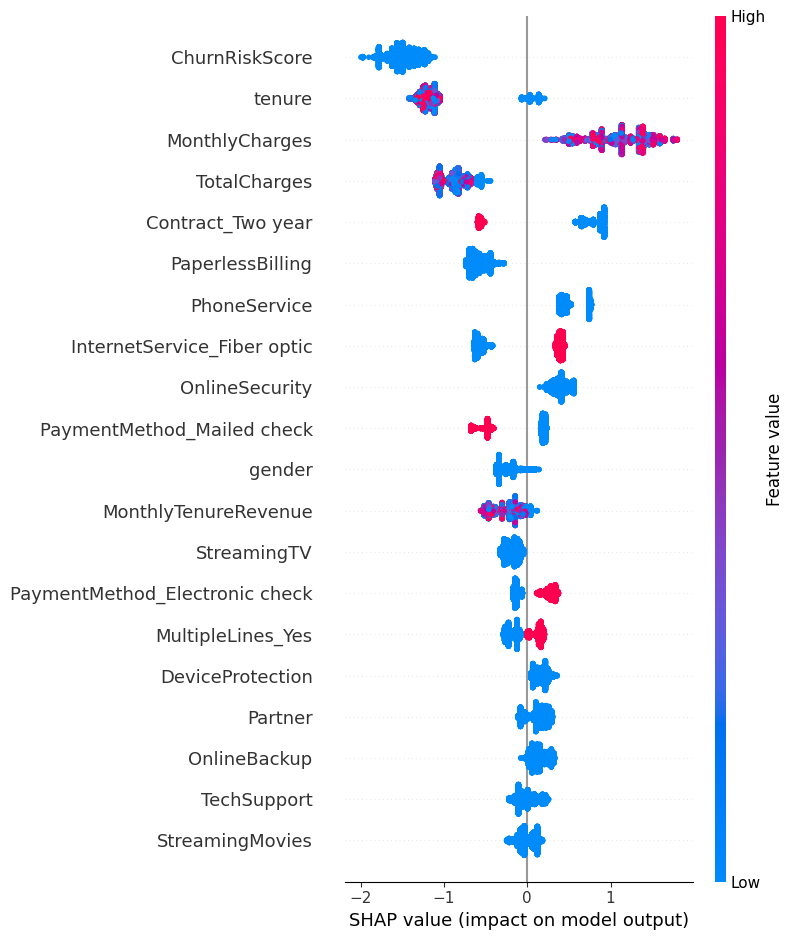

In [42]:
import shap
import matplotlib.pyplot as plt

# Convert Pool to DataFrame for SHAP plotting
X_for_shap = pool_for_shap.get_features()

# shap_values is numpy array, convert to shap.Explanation object
# CatBoost shap_values are (num_samples, num_features+1), last col is expected value excluded already
explainer = shap.Explanation(values=shap_values, data=X_for_shap, feature_names=pool_for_shap.get_feature_names())

# Summary plot (beeswarm)
shap.summary_plot(explainer.values, X_for_shap, feature_names=pool_for_shap.get_feature_names())


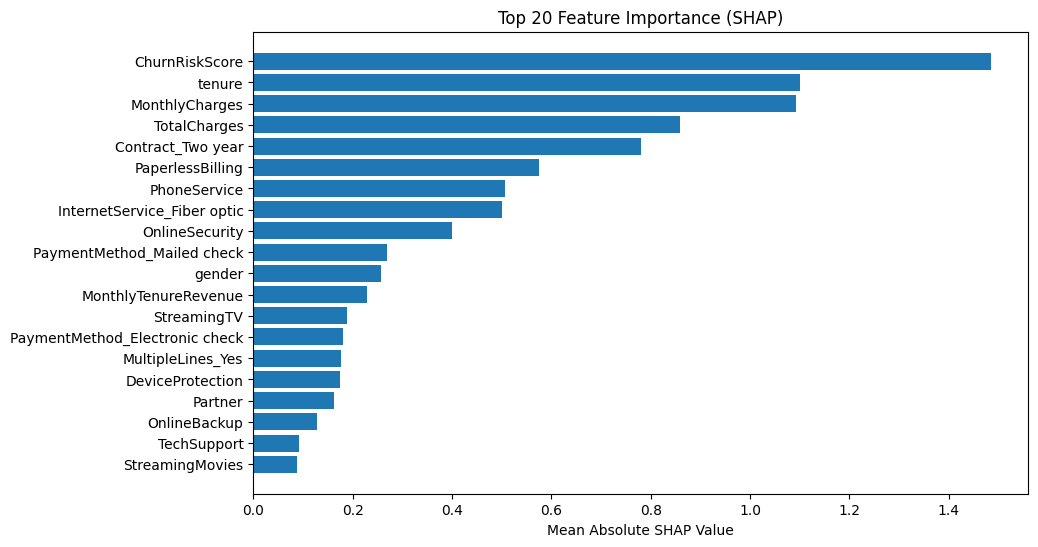

In [43]:
# Mean absolute SHAP value for each feature
mean_abs_shap = np.abs(shap_values).mean(axis=0)
feature_names = pool_for_shap.get_feature_names()

# Sort features by importance
sorted_idx = mean_abs_shap.argsort()[::-1]
sorted_features = [feature_names[i] for i in sorted_idx]
sorted_shap_vals = mean_abs_shap[sorted_idx]

plt.figure(figsize=(10, 6))
plt.barh(sorted_features[:20], sorted_shap_vals[:20])  # Top 20 features
plt.xlabel("Mean Absolute SHAP Value")
plt.title("Top 20 Feature Importance (SHAP)")
plt.gca().invert_yaxis()
plt.show()


In [46]:
print(df.columns)


Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure',
       'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod',
       'MonthlyCharges', 'TotalCharges', 'Churn', 'churn_probability'],
      dtype='object')


In [47]:
# Normalize MonthlyCharges for weighting (scale between 0 and 1)
df['revenue_norm'] = (df['MonthlyCharges'] - df['MonthlyCharges'].min()) / (df['MonthlyCharges'].max() - df['MonthlyCharges'].min())

# Calculate a risk score combining churn probability and normalized revenue
# You can tweak weights if needed
df['business_impact_risk_score'] = df['churn_probability'] * df['revenue_norm']

# View first 5 rows to check
print(df[['churn_probability', 'MonthlyCharges', 'revenue_norm', 'business_impact_risk_score']].head())


   churn_probability  MonthlyCharges  revenue_norm  business_impact_risk_score
0           0.374540           29.85      0.115423                    0.043231
1           0.950714           56.95      0.385075                    0.366096
2           0.731994           53.85      0.354229                    0.259293
3           0.598658           42.30      0.239303                    0.143261
4           0.156019           70.70      0.521891                    0.081425


In [50]:
print(df.columns)


Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure',
       'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod',
       'MonthlyCharges', 'TotalCharges', 'Churn', 'churn_probability'],
      dtype='object')


In [51]:
# Assuming churn_probability and MonthlyCharges are present
df['revenue_norm'] = (df['MonthlyCharges'] - df['MonthlyCharges'].min()) / (df['MonthlyCharges'].max() - df['MonthlyCharges'].min())
df['business_impact_risk_score'] = df['churn_probability'] * df['revenue_norm']

print(df[['churn_probability', 'MonthlyCharges', 'revenue_norm', 'business_impact_risk_score']].head())


   churn_probability  MonthlyCharges  revenue_norm  business_impact_risk_score
0           0.374540           29.85      0.115423                    0.043231
1           0.950714           56.95      0.385075                    0.366096
2           0.731994           53.85      0.354229                    0.259293
3           0.598658           42.30      0.239303                    0.143261
4           0.156019           70.70      0.521891                    0.081425


use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.


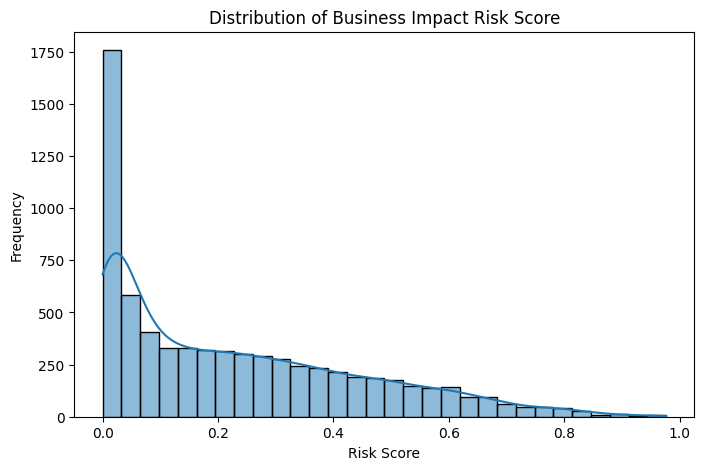

In [52]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot distribution of Business Impact Risk Score
plt.figure(figsize=(8, 5))
sns.histplot(df['business_impact_risk_score'], bins=30, kde=True)
plt.title('Distribution of Business Impact Risk Score')
plt.xlabel('Risk Score')
plt.ylabel('Frequency')
plt.show()


use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.


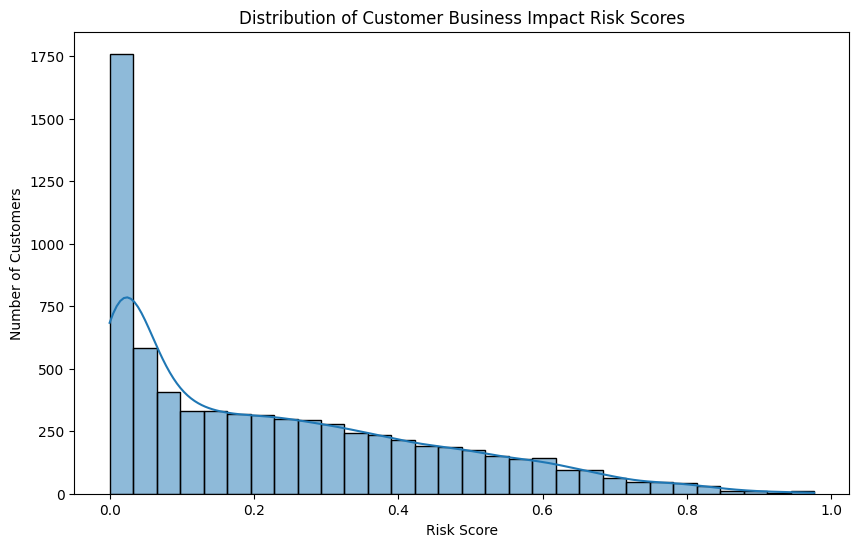

Customers per Risk Segment:
 risk_segment
Low Risk          4249
Medium Risk       1803
High Risk          827
Very High Risk     152
Name: count, dtype: int64


The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


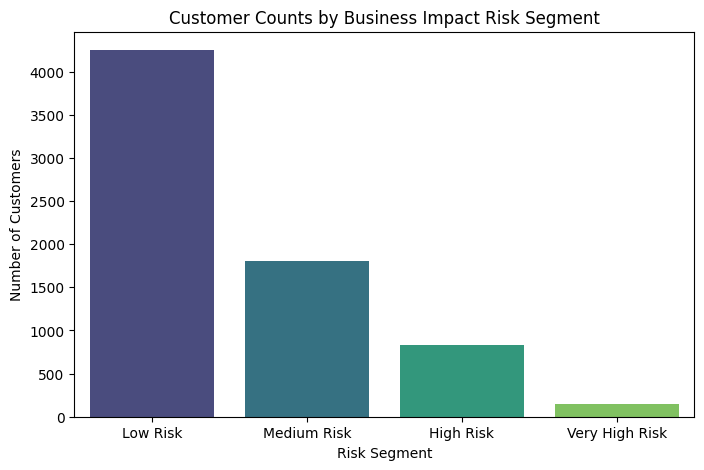

Average Monthly Charges per Risk Segment:
 risk_segment
Low Risk           51.112497
Medium Risk        80.392235
High Risk          93.452539
Very High Risk    106.798026
Name: MonthlyCharges, dtype: float64


The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


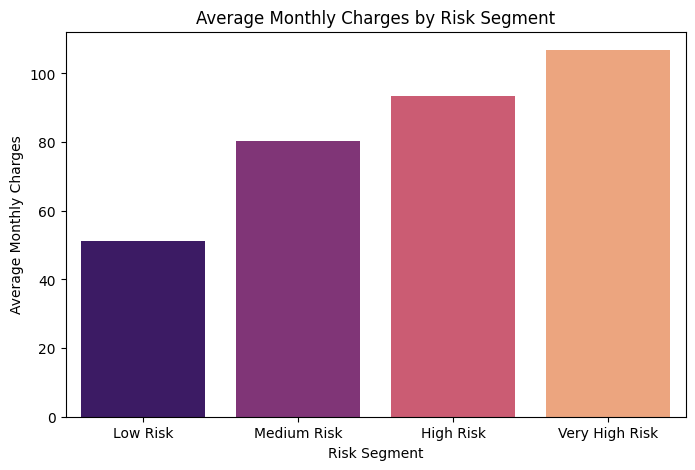

In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('/kaggle/input/cleanedchurneddata/cleaned_churn_data.csv')

# Assuming you have churn_probability column from your model; if not, generate or load it
# Here using your existing churn_probability (replace if needed)
if 'churn_probability' not in df.columns:
    np.random.seed(42)
    df['churn_probability'] = np.random.rand(len(df))

# Normalize MonthlyCharges instead of MonthlyTenureRevenue
df['revenue_norm'] = (df['MonthlyCharges'] - df['MonthlyCharges'].min()) / \
                     (df['MonthlyCharges'].max() - df['MonthlyCharges'].min())

# Calculate business impact risk score
df['business_impact_risk_score'] = df['churn_probability'] * df['revenue_norm']

# Segment customers into risk buckets
risk_bins = [0, 0.25, 0.5, 0.75, 1.0]
risk_labels = ['Low Risk', 'Medium Risk', 'High Risk', 'Very High Risk']
df['risk_segment'] = pd.cut(df['business_impact_risk_score'], bins=risk_bins, labels=risk_labels)

# Visualize the risk score distribution
plt.figure(figsize=(10,6))
sns.histplot(df['business_impact_risk_score'], bins=30, kde=True)
plt.title('Distribution of Customer Business Impact Risk Scores')
plt.xlabel('Risk Score')
plt.ylabel('Number of Customers')
plt.show()

# Count customers per risk segment
risk_counts = df['risk_segment'].value_counts().sort_index()
print("Customers per Risk Segment:\n", risk_counts)

# Plot customers count per risk segment
plt.figure(figsize=(8,5))
sns.barplot(x=risk_counts.index, y=risk_counts.values, palette='viridis')
plt.title('Customer Counts by Business Impact Risk Segment')
plt.ylabel('Number of Customers')
plt.xlabel('Risk Segment')
plt.show()

# Show average MonthlyCharges per risk segment (business insight)
avg_revenue = df.groupby('risk_segment')['MonthlyCharges'].mean()
print("Average Monthly Charges per Risk Segment:\n", avg_revenue)

plt.figure(figsize=(8,5))
sns.barplot(x=avg_revenue.index, y=avg_revenue.values, palette='magma')
plt.title('Average Monthly Charges by Risk Segment')
plt.ylabel('Average Monthly Charges')
plt.xlabel('Risk Segment')
plt.show()

# Save results
df.to_csv('churn_business_impact_risk_scores.csv', index=False)


In [55]:
# Text Summary
print("\n--- Churn Risk Analysis Summary ---\n")
print(f"Total Customers: {len(df)}")
print(f"Low Risk Customers: {risk_counts['Low Risk']} (Avg Charges: ${avg_revenue['Low Risk']:.2f})")
print(f"Medium Risk Customers: {risk_counts['Medium Risk']} (Avg Charges: ${avg_revenue['Medium Risk']:.2f})")
print(f"High Risk Customers: {risk_counts['High Risk']} (Avg Charges: ${avg_revenue['High Risk']:.2f})")
print(f"Very High Risk Customers: {risk_counts['Very High Risk']} (Avg Charges: ${avg_revenue['Very High Risk']:.2f})")
print("\nRecommendation: Focus retention strategies on High and Very High Risk segments where customer value is high.\n")



--- Churn Risk Analysis Summary ---

Total Customers: 7032
Low Risk Customers: 4249 (Avg Charges: $51.11)
Medium Risk Customers: 1803 (Avg Charges: $80.39)
High Risk Customers: 827 (Avg Charges: $93.45)
Very High Risk Customers: 152 (Avg Charges: $106.80)

Recommendation: Focus retention strategies on High and Very High Risk segments where customer value is high.



Churn Probability vs. Monthly Charges (Scatter Plot)

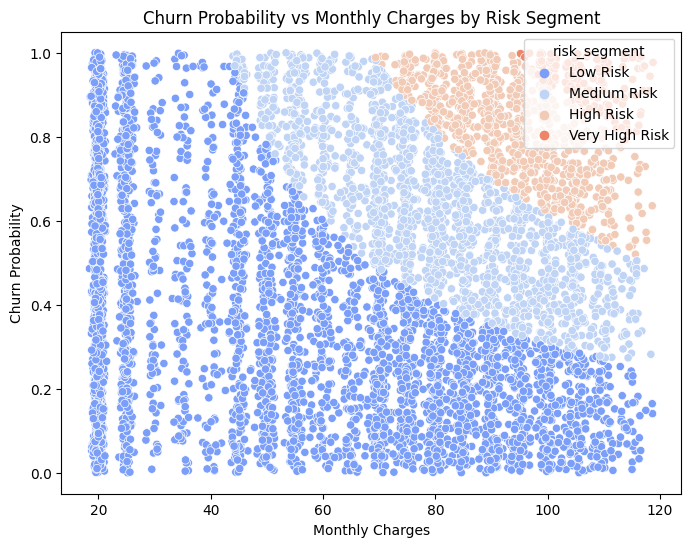

In [56]:
plt.figure(figsize=(8,6))
sns.scatterplot(data=df, x='MonthlyCharges', y='churn_probability', hue='risk_segment', palette='coolwarm')
plt.title('Churn Probability vs Monthly Charges by Risk Segment')
plt.xlabel('Monthly Charges')
plt.ylabel('Churn Probability')
plt.show()


Boxplot: Monthly Charges by Risk Segment

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


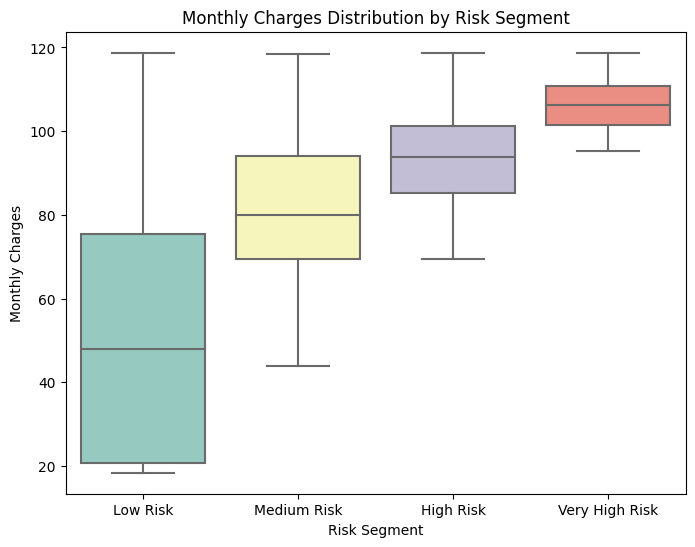

In [57]:
plt.figure(figsize=(8,6))
sns.boxplot(data=df, x='risk_segment', y='MonthlyCharges', palette='Set3')
plt.title('Monthly Charges Distribution by Risk Segment')
plt.xlabel('Risk Segment')
plt.ylabel('Monthly Charges')
plt.show()


Heatmap: Risk Segment vs. Contract Type

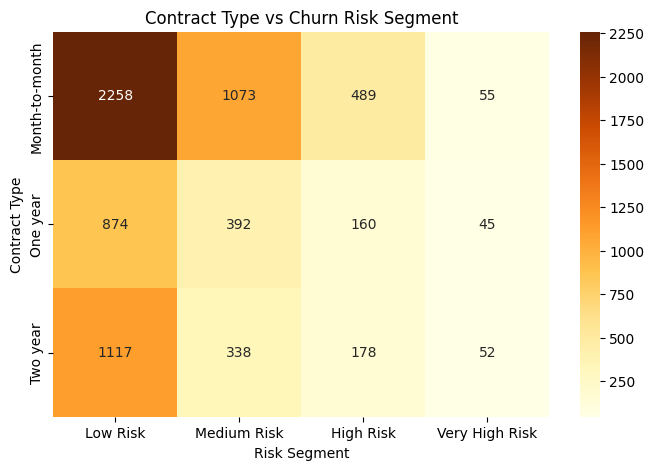

In [58]:
pivot = pd.crosstab(df['Contract'], df['risk_segment'])
plt.figure(figsize=(8,5))
sns.heatmap(pivot, annot=True, fmt='d', cmap='YlOrBr')
plt.title('Contract Type vs Churn Risk Segment')
plt.ylabel('Contract Type')
plt.xlabel('Risk Segment')
plt.show()


Bar Plot: Internet Service Type per Risk Segment

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


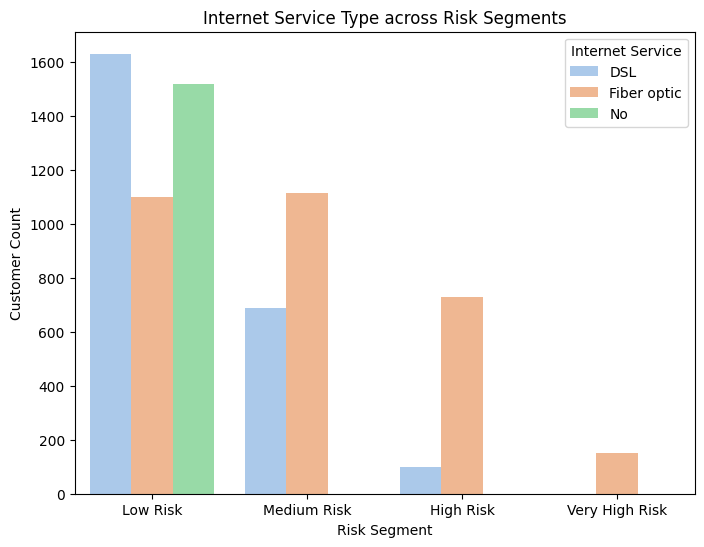

In [59]:
plt.figure(figsize=(8,6))
sns.countplot(data=df, x='risk_segment', hue='InternetService', palette='pastel')
plt.title('Internet Service Type across Risk Segments')
plt.xlabel('Risk Segment')
plt.ylabel('Customer Count')
plt.legend(title='Internet Service')
plt.show()


use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.


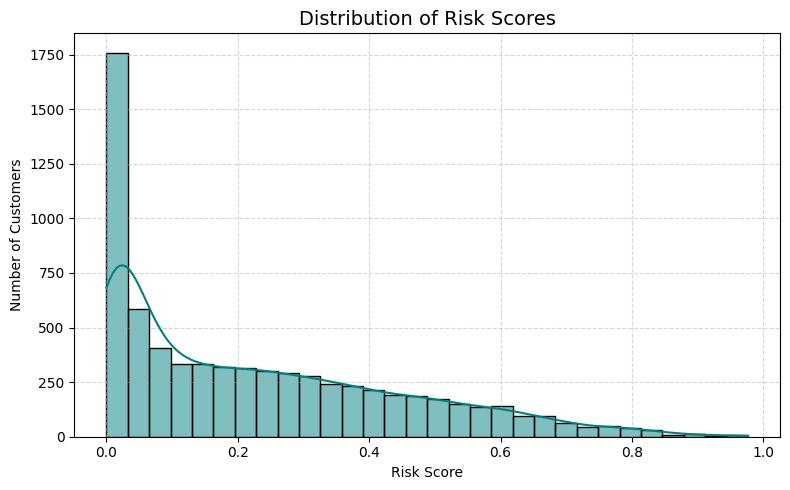

In [63]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 5))
sns.histplot(df['risk_score'], bins=30, kde=True, color='teal')
plt.title('Distribution of Risk Scores', fontsize=14)
plt.xlabel('Risk Score')
plt.ylabel('Number of Customers')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


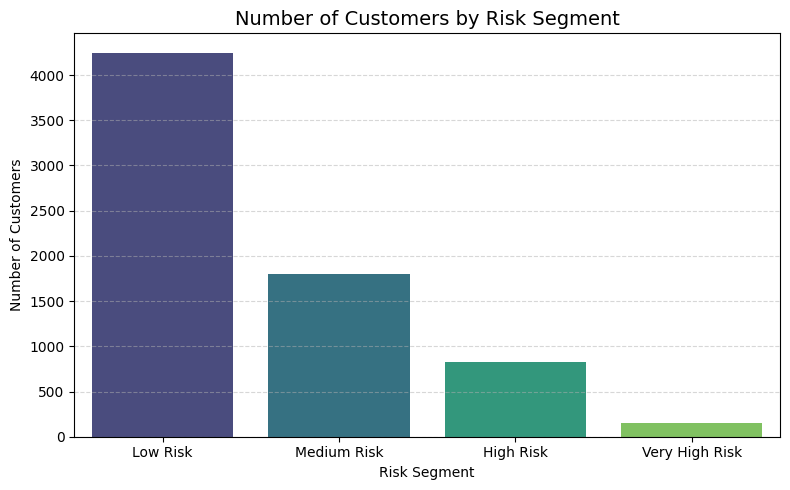

In [64]:
risk_counts = df['risk_segment'].value_counts().sort_index()

plt.figure(figsize=(8, 5))
sns.barplot(x=risk_counts.index, y=risk_counts.values, palette='viridis')
plt.title('Number of Customers by Risk Segment', fontsize=14)
plt.xlabel('Risk Segment')
plt.ylabel('Number of Customers')
plt.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


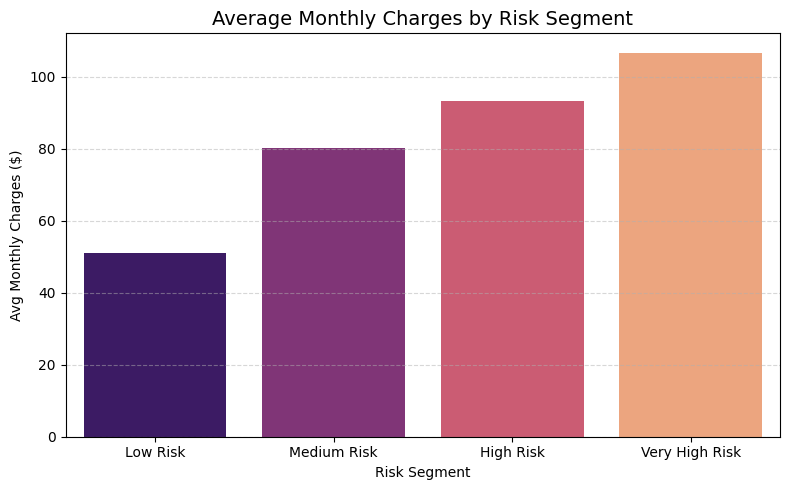

In [65]:
avg_charges = df.groupby('risk_segment')['MonthlyCharges'].mean().sort_index()

plt.figure(figsize=(8, 5))
sns.barplot(x=avg_charges.index, y=avg_charges.values, palette='magma')
plt.title('Average Monthly Charges by Risk Segment', fontsize=14)
plt.xlabel('Risk Segment')
plt.ylabel('Avg Monthly Charges ($)')
plt.grid(True, axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()
